# SWM mapping in the BigBrain

### Libraries

In [1]:
import os
import glob
import nibabel as nb
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
import numpy as np
import seaborn as sns
import pandas as pd
import cmocean
import matplotlib.pyplot as plt
import matplotlib as mpl

### Load surfaces and masks

In [8]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Path to MICAPIPEsurf = mask_5k !
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

# Load fsLR 5k
f5k_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.surf.gii', itype='gii')
f5k_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.surf.gii', itype='gii')

# Boolean mask
mask_surf = mask_5k != 0

### Functions

## F1: Surface-based intensity smoothing and processing for BigBrain

In [3]:
# Function: Smooth intensity profiles on a given surface
def smooth_surf(surf_l, surf_r, points, Mask, Kernel='uniform', Niter=3, Relax=0.35):
    '''
    Smooths intensity data on a given surface mesh using iterative smoothing.
    
    Parameters:
    -----------
    surf_l : np.array
        Left hemisphere surface connectivity.
    surf_r : np.array
        Right hemisphere surface connectivity.
    points : np.array
        Intensity profile data mapped to the surface.
    Mask : np.array
        Binary mask indicating valid regions for smoothing.
    Kernel : str, optional
        Smoothing kernel type, options: {'uniform', 'gaussian', 'inverse_distance'}.
    Niter : int, optional
        Number of smoothing iterations (default: 3).
    Relax : float, optional
        Relaxation factor controlling smoothing intensity (default: 0.35).
    
    Returns:
    --------
    sdata : np.array
        Smoothed intensity data.
    '''
    Ndim = Mask.shape[0] 
    n2dim = int(Ndim/2)
    Mask_l = Mask[:n2dim]
    Mask_r = Mask[n2dim:]
    
    sdata = np.concatenate((
        smooth_array(surf_l, points[:n2dim], kernel=Kernel, n_iter=Niter, relax=Relax, mask=Mask_l), 
        smooth_array(surf_r, points[n2dim:], kernel=Kernel, n_iter=Niter, relax=Relax, mask=Mask_r)
    ), axis=0)
    
    return sdata

# Function: Apply smoothing to intensity profiles across all depths
def smooth_intensities(int_profile):
    '''
    Applies surface smoothing to each depth of the intensity profile.
    
    Parameters:
    -----------
    int_profile : np.array
        Input intensity profiles, where rows represent different depths.
    
    Returns:
    --------
    smoothed_i : np.array
        Smoothed intensity profiles.
    '''
    smoothed_i = np.copy(int_profile)
    
    for i in range(int_profile.shape[0]):
        smoothed_i[i, :] = smooth_surf(
            inf_lh, inf_rh, int_profile[i, :], mask_surf, Niter=5, Relax=0.5, Kernel='uniform'
        )
    
    return smoothed_i

## F2: Functions for correcting outliers

In [4]:
def fill_missing_Turkey(cdata):
    # Calculate the first and third quartiles
    Q1 = np.nanpercentile(cdata, 25)
    Q3 = np.nanpercentile(cdata, 75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the outlier thresholds based on Tukey's method
    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR

    # Identify outliers based on Tukey's method
    outliers = (cdata < lower_threshold) | (cdata > upper_threshold)

    # Set outliers to NaN
    cdata[outliers] = np.nan

    # Interpolate NaNs
    good = np.where(~np.isnan(cdata))
    bad = np.where(np.isnan(cdata))
    fill = scipy.interpolate.griddata(good, cdata[good], bad)
    cdata[bad] = fill

    # Extrapolate any remaining missing values
    good = np.where(~np.isnan(cdata))
    bad = np.where(np.isnan(cdata))
    fill = scipy.interpolate.griddata(good, cdata[good], bad, method='nearest')
    cdata[bad] = fill
    
    return cdata

## F3: Functions for loading data

In [5]:
def load_SWM_group_5k(surf):
    """
    Load and process superficial white matter (SWM) intensity profiles for a given surface resolution.
    
    Parameters:
    surf (str): Surface type ('fsLR32k', 'fsLR5k', or 'fsaverage5').
    
    Returns:
    tuple: Mean intensity profile and smoothed intensity profiles.
    """
    # Set directories based on the surface type
    if surf == 'fsLR32k':
        dir_surf = "/host/percy/local_raid/youngeun/sub-BigBrain/Histological-Space/200um/SWM_50map-fsLR32k/"
    elif surf == 'fsLR5k':
        dir_surf = "/host/percy/local_raid/youngeun/sub-BigBrain/Histological-Space/200um/SWM_50map-fsLR5k/"
    elif surf == 'fsaverage5':
        dir_surf = "/host/percy/local_raid/youngeun/sub-BigBrain/Histological-Space/200um/SWM_50map-fsaverage5/"
    
    # List the left and right hemisphere files
    files_lh = sorted(glob.glob(dir_surf + f"sub-BigBrain_hemi-L_surf-{surf}_label-swm*mm.func.gii"))
    files_rh = sorted(glob.glob(dir_surf + f"sub-BigBrain_hemi-R_surf-{surf}_label-swm*mm.func.gii"))
    
    # Load SWM data and concatenate left and right hemisphere data
    Nqmri = np.concatenate((nb.load(files_lh[0]).darrays[0].data, nb.load(files_rh[0]).darrays[0].data), axis=0).shape[0]
    surf_map = np.empty([len(files_lh), Nqmri], dtype=float)
    for i, _ in enumerate(files_lh):
        surf_map[i, :] = np.hstack(np.concatenate((nb.load(files_lh[i]).darrays[0].data, nb.load(files_rh[i]).darrays[0].data), axis=0))
    
    # Fill missing data using Turkey's method
    filled_matrix = np.empty_like(surf_map)
    for i, row in enumerate(surf_map):
        filled_matrix[i] = fill_missing_Turkey(row)
    
    # Smooth intensity profiles
    profile_smooth = smooth_intensities(filled_matrix)
    
    # Replace values in midwall with NaN where mask is False
    profile_smooth[:, mask_5k == False] = np.nan
    
    # Compute mean intensity profile across vertices
    map_mean = np.mean(profile_smooth, axis=0)
    
    N = filled_matrix.shape[0]     
    print(f"Number of surfaces: {N}") 
    
    return map_mean, profile_smooth

def load_GM_group_5k():
    """
    Load and process gray matter (GM) intensity profiles for fsLR5k surface.
    
    Returns:
    tuple: Mean intensity profile and smoothed intensity profiles.
    """
    # Set directory for gray matter data
    dir_surf = "/host/percy/local_raid/youngeun/sub-BigBrain/Histological-Space/from_BigBrainWarp/fsLR5k/"
    
    # List the left and right hemisphere files
    files_lh = sorted(glob.glob(dir_surf + f"fsLR-5k.L_bigbrain_*.func.gii"))
    files_rh = sorted(glob.glob(dir_surf + f"fsLR-5k.R_bigbrain_*.func.gii"))
    
    # Load GM data and concatenate left and right hemisphere data
    Nqmri = np.concatenate((nb.load(files_lh[0]).darrays[0].data, nb.load(files_rh[0]).darrays[0].data), axis=0).shape[0]
    surf_map = np.empty([len(files_lh), Nqmri], dtype=float)
    for i, _ in enumerate(files_lh):
        surf_map[i, :] = np.hstack(np.concatenate((nb.load(files_lh[i]).darrays[0].data, nb.load(files_rh[i]).darrays[0].data), axis=0))
    
    # Fill missing data using Turkey's method
    filled_matrix = np.empty_like(surf_map)
    for i, row in enumerate(surf_map):
        filled_matrix[i] = fill_missing_Turkey(row)
    
    # Smooth intensity profiles
    profile_smooth = smooth_intensities(filled_matrix)
    
    # Replace values in midwall with NaN where mask is False
    profile_smooth[:, mask_5k == False] = np.nan
    
    # Compute mean intensity profile across vertices
    map_mean = np.mean(profile_smooth, axis=0)
    
    N = filled_matrix.shape[0]     
    print(f"Number of surfaces: {N}") 
    
    return map_mean, profile_smooth

## F4: Ridge plot for visualizing histological intensity distributions

In [11]:
## # Function: Generate a ridge plot to visualize intensity distributions across subjects

def plot_ridgeplot(matrix, matrix_df=None, Cmap='rocket', Range=(2.5, 4.5), Xlab="flair", save_path=None, title=None):
    '''
    Creates a ridge plot (stacked density plots) to visualize intensity distributions across different subjects.
    
    Parameters:
    -----------
    matrix : np.array
        Input intensity profile matrix, where each row represents a subject.
    matrix_df : list, optional
        Labels corresponding to each row of the matrix (e.g., subject IDs).
    Cmap : str, optional
        Colormap for the visualization (default: 'rocket').
    Range : tuple, optional
        X-axis limits (default: (2.5, 4.5)).
    Xlab : str, optional
        X-axis label (default: "flair").
    save_path : str, optional
        If provided, saves the figure to the specified path instead of displaying it.
    title : str, optional
        Title for the entire plot.
    '''
    
    # Flatten intensity matrix and prepare subject and ID labels
    ai = matrix.flatten()
    subject = np.array([])
    id_x = np.array([])
    
    for i in range(matrix.shape[0]):
        label = np.array([str(i+1) for j in range(matrix.shape[1])])
        subject = np.concatenate((subject, label))
        id_label = np.array([matrix_df[i] for j in range(matrix.shape[1])])
        id_x = np.concatenate((id_x, id_label))
    
    # Create DataFrame for plotting
    df = pd.DataFrame({
        'feature': ai,
        'subject': subject,
        'id_x': id_x
    })
    
    # Initialize figure and axes for ridge plot
    f, axs = plt.subplots(nrows=matrix.shape[0], figsize=(3.468504*2.5, 2.220472*3.5), sharex=True, sharey=True)
    f.set_facecolor('none')
    
    x = np.linspace(Range[0], Range[1], 100)  # Define x-axis range
    
    for i, ax in enumerate(axs, 1):
        # Plot density estimation
        sns.kdeplot(df[df["subject"]==str(i)]['feature'],
                    fill=True,
                    color="w",
                    alpha=0.25,
                    linewidth=1.5,
                    legend=False,
                    ax=ax)
        
        ax.set_xlim(Range[0], Range[1])
        
        # Overlay colormap
        im = ax.imshow(np.vstack([x, x]),
                       cmap=Cmap,
                       aspect="auto",
                       extent=[*ax.get_xlim(), *ax.get_ylim()]
                      )
        
        # Clip colormap to density shape
        path = ax.collections[0].get_paths()[0]
        patch = mpl.patches.PathPatch(path, transform=ax.transData)
        im.set_clip_path(patch)
        
        # Remove unnecessary plot borders
        ax.spines[['left','right','bottom','top']].set_visible(False)
        
        # Hide x-axis ticks except for the last plot
        if i != matrix.shape[0]:
            ax.tick_params(axis="x", length=0)
        else:
            ax.set_xlabel(Xlab)
        
        ax.set_yticks([])
        ax.set_ylabel("")
        ax.axhline(0, color="black")
        ax.set_facecolor("none")
    
    # Add subject labels to the left side of each plot
    for i, ax in enumerate(axs):
        if i == matrix.shape[0] - 1:
            ax.set_xticks([Range[0], Range[1]])  # Set x-axis ticks for the bottom plot
        else:
            ax.set_xticks([])  # Remove x-axis ticks from other plots
        ax.text(0.05, 0.01, matrix_df[i], transform=ax.transAxes, fontsize=10, color='black', ha='left', va='bottom')
    
    plt.subplots_adjust(hspace=-0.8)  # Adjust spacing between plots
    
    # Add title if provided
    if title:
        plt.suptitle(title, y=0.99, fontsize=16)
    
    # Save or display the plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    else:
        plt.show()


## F5: Plot intensity profiles

In [18]:
def plot_filtered_pcolormesh(data, mask, color_range=(42000,58000), figsize=(15, 8), cmap='gray'):
    """
    Plot a filtered pcolormesh after removing NaN-containing vertices.

    Parameters:
        data (ndarray): 2D array representing the data to be plotted.
        mask (ndarray): Boolean mask indicating valid vertices (True = valid, False = remove).
        color_range (tuple): Range for colormap scaling (vmin, vmax).
        figsize (tuple): Figure size (width, height).
        cmap (str): Colormap for visualization.
    """

    # Mask out invalid vertices
    data[:, mask == False] = np.nan
    valid_vertices = ~np.isnan(data).any(axis=0)
    filtered_data = data[:, valid_vertices]
    filtered_data = filtered_data[::-1, :]

    # Create figure
    plt.figure(figsize=figsize)

    # Plot the pcolormesh
    pcm = plt.pcolormesh(filtered_data, cmap=cmap, shading='auto', vmin=color_range[0], vmax=color_range[1])

    # Remove axis labels
    plt.xticks([])
    plt.yticks([])

    # Add colorbar
    plt.colorbar(pcm)

    # Show plot
    plt.show()

## Plot mean intensity

### Outliers corrected + Smoothed fsLR5k

In [6]:
mean5k, map5k = load_SWM_group_5k(surf='fsLR5k')
mean5k[mask_5k==False] = np.nan

Number of surfaces: 51


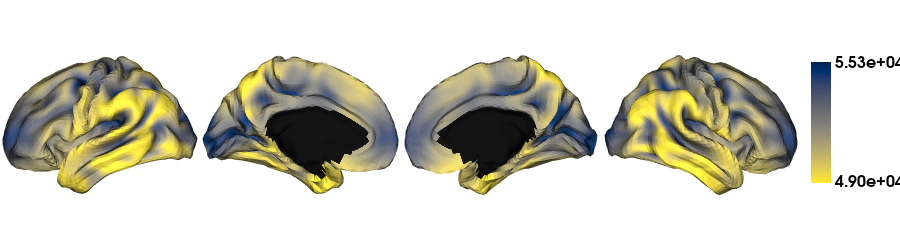

In [9]:
# Plot average SWM surfaces
crange=(np.quantile(mean5k[mask_5k==True], 0.05), np.quantile(mean5k[mask_5k==True], 0.99))
plot_hemispheres(f5k_lh, f5k_rh, array_name=mean5k, size=(900, 250), color_bar='right', zoom=1.25, embed_nb=True, interactive=False, share='both', nan_color=(0, 0, 0, 1), 
                 cmap='cividis_r', transparent_bg=False, screenshot=False, color_range=crange)

## Plot intensities

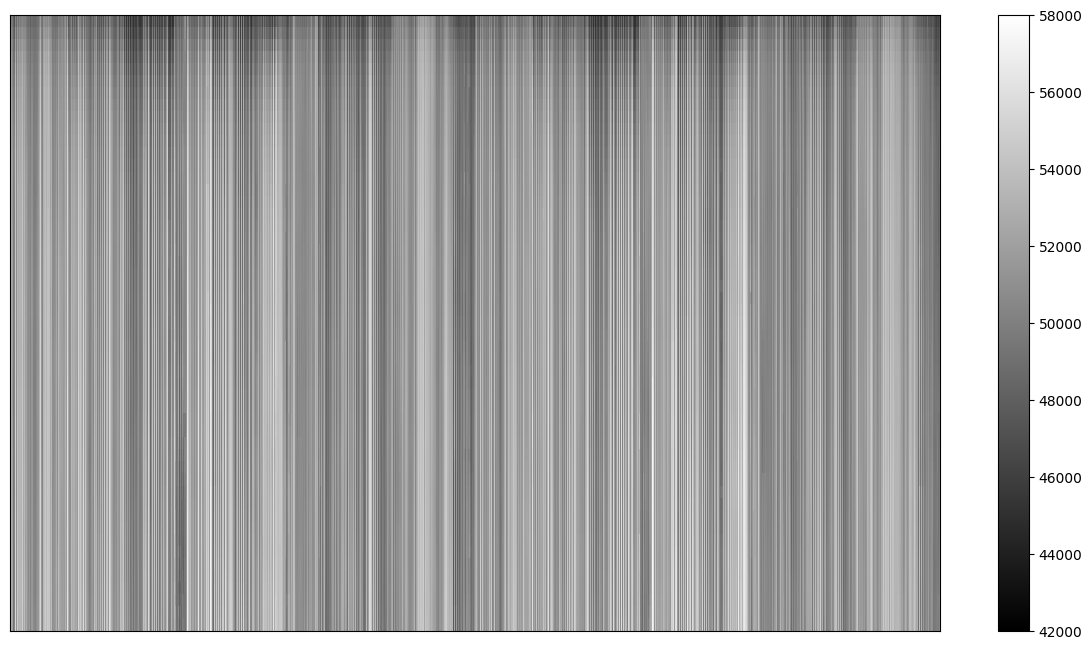

In [19]:
plot_filtered_pcolormesh(map5k, mask_5k)

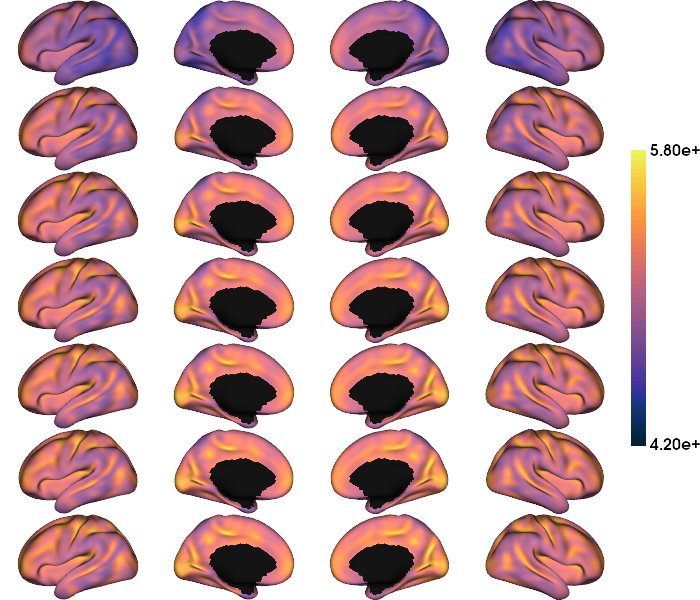

In [12]:
rows_to_extract = [0, 5, 10, 15, 20, 25, 30]
BBextracted_rows = map5k[rows_to_extract]

labels = [str(x)+' mm' for x in [0.00, 0.30, 0.60, 0.90, 1.20, 1.80]]
BBextracted_rows[:, mask_5k == False] = np.nan

# Calculate the quantiles for the color range
map_crange=(np.quantile(BBextracted_rows[:, mask_5k], 0.1), np.quantile(BBextracted_rows[:, mask_5k], 1))

# Plot with the new color range
plot_hemispheres(inf_lh, inf_rh, array_name=BBextracted_rows, size=(700, 600), color_bar='right', zoom=1.8, embed_nb=True, interactive=False, share='both', nan_color=(0, 0, 0, 1), 
                 cmap='cmo.thermal', transparent_bg=True, screenshot=False, color_range=(42000,58000))

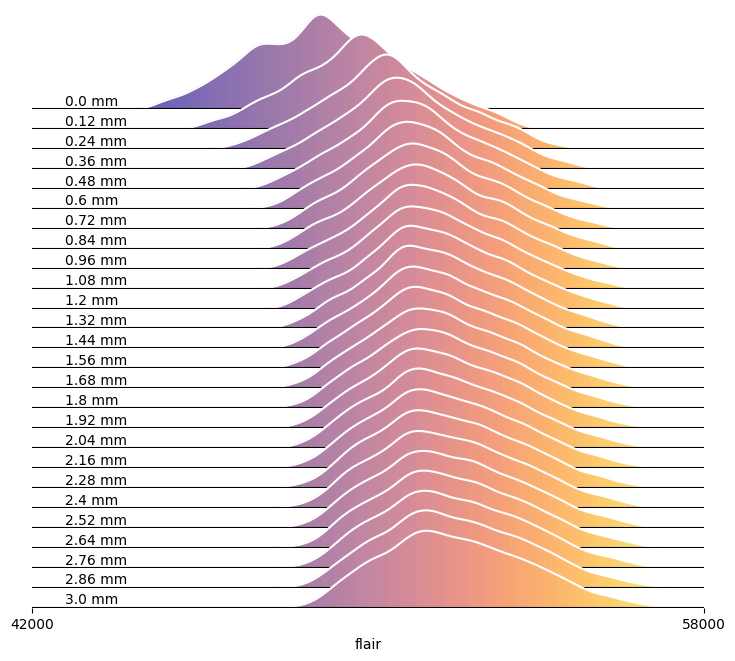

In [14]:
rows_to_extract = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]
extracted_rows = map5k[rows_to_extract]

labels = [str(x)+' mm' for x in [0.00, 0.12, 0.24, 0.36, 0.48, 0.60, 0.72, 0.84, 0.96, 1.08, 1.20, 1.32, 1.44, 1.56, 1.68, 1.80, 1.92, 2.04, 2.16, 2.28, 2.40, 2.52, 2.64, 2.76, 2.86, 3.00]]
plot_img = extracted_rows
plot_img[:, mask_5k == False] = np.nan

# Identify rows with NaN values and exclude them
valid_rows = ~np.isnan(plot_img).any(axis=0)
masked_plot_img = plot_img[:, valid_rows]

plot_ridgeplot(matrix=plot_img, matrix_df=labels, Cmap='cmo.thermal', Range=(42000, 58000))